In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import h5py
import numpy as np
import random
from imutils import paths
from google.colab.patches import cv2_imshow  # Import for displaying images in Colab

# Define paths
input_folder = "/content/drive/MyDrive/Images/"  # Folder containing original images
output_folder = "/content/drive/MyDrive/ROTATE2__IMAGE"  # Folder to save rotated images


# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Define possible rotation angles
angles = [0, 90, 180, 270]

# Initialize lists to store image data and labels
image_data = []
labels = []

# Get image paths
imagePaths = list(paths.list_images(input_folder))

print("[INFO] Creating dataset with one random rotation per image...")

# Counter for tracking progress
processed_count = 0

for imagePath in imagePaths:
    # Read the image
    image = cv2.imread(imagePath)
    if image is None:
        continue

    # Resize image to a fixed size (224x224)
    image = cv2.resize(image, (224, 224))

    # Select one random rotation angle for this image
    angle = random.choice(angles)

    # Rotate the image
    if angle == 0:
        rotated = image.copy()  # No rotation, use original image
    else:
        rotated = cv2.rotate(image, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])

    # Save rotated image to disk
    filename = f"rotated_{angle}_{os.path.basename(imagePath)}"
    save_path = os.path.join(output_folder, filename)
    cv2.imwrite(save_path, rotated)

    # Convert image to NumPy array and normalize
    rotated = rotated.astype("float32") / 255.0

    # Append image and label to lists
    image_data.append(rotated)
    labels.append(angle)

    # Increment counter
    processed_count += 1

    # Print progress every 500 images
    if processed_count % 500 == 0:
        print(f"[INFO] Processed {processed_count} images so far...")

# Convert lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)



[INFO] Creating dataset with one random rotation per image...
[INFO] Processed 500 images so far...
[INFO] Processed 1000 images so far...
[INFO] Processed 1500 images so far...
[INFO] Processed 2000 images so far...
[INFO] Processed 2500 images so far...
[INFO] Processed 3000 images so far...
[INFO] Processed 3500 images so far...
[INFO] Processed 4000 images so far...
[INFO] Processed 4500 images so far...
[INFO] Processed 5000 images so far...
[INFO] Processed 5500 images so far...
[INFO] Processed 6000 images so far...
[INFO] Processed 6500 images so far...
[INFO] Processed 7000 images so far...
[INFO] Processed 7500 images so far...
[INFO] Processed 8000 images so far...
[INFO] Processed 8500 images so far...
[INFO] Processed 9000 images so far...
[INFO] Processed 9500 images so far...
[INFO] Processed 10000 images so far...
[INFO] Processed 10500 images so far...
[INFO] Processed 11000 images so far...
[INFO] Processed 11500 images so far...
[INFO] Processed 12000 images so far..

In [ ]:
import h5py
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from imutils import paths
import numpy as np
import progressbar
import random
import os

# Directly assign dataset and output paths
dataset_path = '/content/drive/MyDrive/ROTATE2__IMAGE'  # Your dataset path in Google Drive
output_path = '/content/drive/MyDrive/output_features.hdf5'  # Output path for HDF5 file in Google Drive

# Parameters
batch_size = 32
buffer_size = 1000

# grab the list of images and shuffle them
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
random.shuffle(imagePaths)

# extract the rotation angle from the image filenames
labels = []
for p in imagePaths:
    filename = os.path.basename(p)  # Get the file name from path
    angle = int(filename.split('_')[1])  # The second element after 'rotate_' is the angle
    labels.append(angle)

# encode the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top=False)

# Open the HDF5 file and create datasets for features and labels
with h5py.File(output_path, 'w') as hdf:
    # Create datasets to store features and labels
    features_dataset = hdf.create_dataset('features', (len(imagePaths), 512 * 7 * 7), dtype='float32')
    labels_dataset = hdf.create_dataset('labels', (len(imagePaths),), dtype='int')

    # Store the class labels as metadata
    hdf.attrs['class_labels'] = le.classes_

    # initialize the progress bar
    widgets = ["Extracting Features: ", progressbar.Percentage(), " ",
        progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(imagePaths), widgets=widgets).start()

    # loop over images in patches
    for i in np.arange(0, len(imagePaths), batch_size):
        batchPaths = imagePaths[i: i + batch_size]
        batchLabels = labels[i: i + batch_size]
        batchImages = []

        for (j, imagePath) in enumerate(batchPaths):
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = imagenet_utils.preprocess_input(image)
            batchImages.append(image)

        batchImages = np.vstack(batchImages)
        features = model.predict(batchImages, batch_size=batch_size)

        features = features.reshape((features.shape[0], 512 * 7 * 7))

        # Store features and labels in the HDF5 dataset
        features_dataset[i:i + len(features)] = features
        labels_dataset[i:i + len(features)] = batchLabels
        pbar.update(i)

    pbar.finish()


[INFO] loading images...
[INFO] loading network...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting Features:   0% |                                    | ETA:  --:--:--

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting Features: 100% |####################################| Time:  0:05:32


In [ ]:
import h5py

# Open the HDF5 file
db_path = '/content/drive/MyDrive/output_features.hdf5'  # Path to your HDF5 file
db = h5py.File(db_path, mode="r")

# List all keys in the HDF5 file
print("Keys in the HDF5 file:", list(db.keys()))

# Optionally, print the attributes of the HDF5 file
print("Attributes of the HDF5 file:", dict(db.attrs))

# Close the HDF5 file
db.close()


Keys in the HDF5 file: ['features', 'labels']
Attributes of the HDF5 file: {'class_labels': array([  0,  90, 180, 270])}


In [ ]:
import h5py
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

# Directly assign dataset and model paths
db_path = '/content/drive/MyDrive/output_features.hdf5'  # Path to your HDF5 file in Google Drive
model_output_path = '/content/drive/MyDrive/logistic_regression_model.pkl'  # Path to save the trained model

# Open HDF5 database for reading
db = h5py.File(db_path, mode="r")

# Access the 'class_labels' attribute for the label names and convert to strings
label_names = [str(label) for label in db.attrs['class_labels']]

# Determine the index of the training and testing split
i = int(db["labels"].shape[0] * 0.75)

# Define the set of parameters to tune when we start a grid search
print("[INFO] tuning hyperparameters...")
params = {"C": [0.01, 0.1, 1.0, 10.0, 100.0]}
model = GridSearchCV(LogisticRegression(), params, cv=3, n_jobs=-1)
model.fit(db["features"][:i], db["labels"][:i])
print("[INFO] best hyperparameters: {}".format(model.best_params_))

# Evaluate the model
print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(classification_report(db["labels"][i:], preds,
                            target_names=label_names))  # Use label_names here

# Serialize the model to disk
print("[INFO] saving model...")
with open(model_output_path, "wb") as f:
    f.write(pickle.dumps(model.best_estimator_))

# Close the database
db.close()


[INFO] tuning hyperparameters...
[INFO] best hyperparameters: {'C': 1.0}
[INFO] evaluating...
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1002
          90       0.87      0.85      0.86       945
         180       0.89      0.89      0.89       988
         270       0.84      0.89      0.86       992

    accuracy                           0.88      3927
   macro avg       0.89      0.88      0.88      3927
weighted avg       0.89      0.88      0.89      3927

[INFO] saving model...


In [ ]:
import pickle
import numpy as np
import cv2
import imutils
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# ✅ Define paths
model_output_path = '/content/drive/MyDrive/logistic_regression_model.pkl'  # Path to save the trained model
image_path = "/content/drive/MyDrive/ROTAT__IMAGE/rotated_270_UltiPro.jpg"  # Path to the image to correct

# ✅ Load trained Logistic Regression model
print("[INFO] Loading trained model...")
with open(model_output_path, "rb") as f:
    model = pickle.load(f)

# ✅ Load VGG16 for feature extraction
print("[INFO] Loading VGG16 model...")
vgg = VGG16(weights="imagenet", include_top=False)


[INFO] Loading trained model...
[INFO] Loading VGG16 model...


In [ ]:
# ✅ Load and preprocess the image
print("[INFO] Processing image...")
orig = cv2.imread(image_path)  # Load using OpenCV

image = load_img(image_path, target_size=(224, 224))  # Resize
image = img_to_array(image)  # Convert to array
image = np.expand_dims(image, axis=0)  # Expand dimensions
image = preprocess_input(image)  # Preprocessing for VGG16

# ✅ Extract features using VGG16
print("[INFO] Extracting features...")
features = vgg.predict(image)
features = features.flatten().reshape(1, -1)  # Flatten & reshape


[INFO] Processing image...
[INFO] Extracting features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


[INFO] Predicted rotation angle: 270°


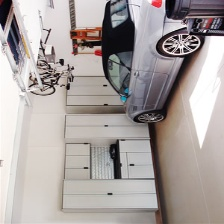

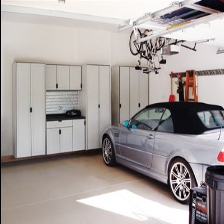

In [ ]:
from google.colab.patches import cv2_imshow

# ✅ Predict the image orientation
pred_angle_index = model.predict(features)[0]  # Get predicted class (0,1,2,3)
angle = int(pred_angle_index) * 90  # Convert index to actual angle

print(f"[INFO] Predicted rotation angle: {angle}°")

# ✅ Correct the image orientation
corrected = imutils.rotate_bound(orig, 360 - angle)  # Rotate to correct

# ✅ Display images correctly in Colab
cv2_imshow(orig)  # Show original image
cv2_imshow(corrected)  # Show corrected image
